In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


**Model’s Objective**
The primary objective of this model is to fine-tune BERT to generate sentence embeddings that capture the semantic relationships between sentence pairs in the SNLI dataset. This is useful for tasks like semantic search, sentence similarity, and other natural language understanding applications.

In [2]:
!pip install sentence_transformers==2.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
%cd /content/gdrive/MyDrive/Colab_Nootebooks/DSCI691/snli_1.0

/content/gdrive/MyDrive/Colab_Nootebooks/DSCI691/snli_1.0


In [4]:
import math
from sentence_transformers import models, losses, datasets, LoggingHandler, SentenceTransformer, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime
import sys
import os
import gzip
import csv
import random
import pandas as pd

In [5]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [6]:
# Define model parameters
model_name = "bert-base-uncased"
train_batch_size = 4
max_seq_length = 128
num_epochs = 10

In [7]:
# Initialize the model
word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode="mean")
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
# Load the SNLI dataset
def load_snli(file_path):
    return pd.read_json(file_path, lines=True)

train_df = load_snli('snli_1.0_train.jsonl')
dev_df = load_snli('snli_1.0_dev.jsonl')
test_df = load_snli('snli_1.0_test.jsonl')

In [9]:
# Reduce the dataset size for testing
train_df = train_df.sample(5000)  # Sample 5000 examples from the training set
dev_df = dev_df.sample(1000)  # Sample 1000 examples from the validation set
test_df = test_df.sample(1000)  # Sample 1000 examples from the test set

In [10]:
# Preprocess the data
train_df = train_df.rename(columns={"sentence1": "sent1", "sentence2": "sent2", "gold_label": "label"})
dev_df = dev_df.rename(columns={"sentence1": "sent1", "sentence2": "sent2", "gold_label": "label"})
test_df = test_df.rename(columns={"sentence1": "sent1", "sentence2": "sent2", "gold_label": "label"})

In [11]:
# Filter out invalid labels
train_df = train_df[train_df['label'].isin(['entailment', 'neutral', 'contradiction'])]
dev_df = dev_df[dev_df['label'].isin(['entailment', 'neutral', 'contradiction'])]
test_df = test_df[test_df['label'].isin(['entailment', 'neutral', 'contradiction'])]

In [12]:
# Map labels to integers
label_mapping = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
train_df['labels'] = train_df['label'].map(label_mapping)
dev_df['labels'] = dev_df['label'].map(label_mapping)
test_df['labels'] = test_df['label'].map(label_mapping)

In [13]:
# Convert DataFrame to InputExample
def convert_to_input_examples(df):
    return [InputExample(texts=[row['sent1'], row['sent2']], label=row['labels']) for idx, row in df.iterrows()]

train_samples = convert_to_input_examples(train_df)
dev_samples = convert_to_input_examples(dev_df)
test_samples = convert_to_input_examples(test_df)

In [14]:
# Create DataLoader
train_dataloader = datasets.NoDuplicatesDataLoader(train_samples, batch_size=train_batch_size)
dev_dataloader = datasets.NoDuplicatesDataLoader(dev_samples, batch_size=train_batch_size)
test_dataloader = datasets.NoDuplicatesDataLoader(test_samples, batch_size=train_batch_size)

In [15]:
# Define the loss function
train_loss = losses.MultipleNegativesRankingLoss(model)

In [24]:
# Save path of the model
model_save_path = (
    "/content/gdrive/MyDrive/Colab_Notebooks/output/training_SNLI_v2_10epochs_" + model_name.replace("/", "-") + "-" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)


In [17]:
# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up
logger.info("Warmup-steps: {}".format(warmup_steps))

In [18]:
# Train the model with mixed precision training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
    use_amp=True,  # Enable mixed precision training
)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1248 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1248 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1248 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1248 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1248 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1248 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1248 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1248 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1248 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1248 [00:00<?, ?it/s]

In [25]:
model.save(model_save_path)
logger.info(f"Model training completed and saved at: {model_save_path}")

In [28]:
model_save_path = "/content/gdrive/MyDrive/Colab_Notebooks/output/training_SNLI_v2_10epochs_bert-base-uncased-2024-06-04_19-26-36"

In [29]:
loaded_model = SentenceTransformer(model_save_path)

In [30]:
sentences = ["This is an example sentence.", "Each sentence is converted"]

# Encode sentences using the loaded model
embeddings = loaded_model.encode(sentences)

print(embeddings)

[[-0.35946795  0.15451625 -0.18752535 ... -0.11973894 -0.88897943
   0.9326766 ]
 [-0.2131088   1.0748343  -0.03272565 ... -0.34132445 -0.37468207
   0.43564382]]


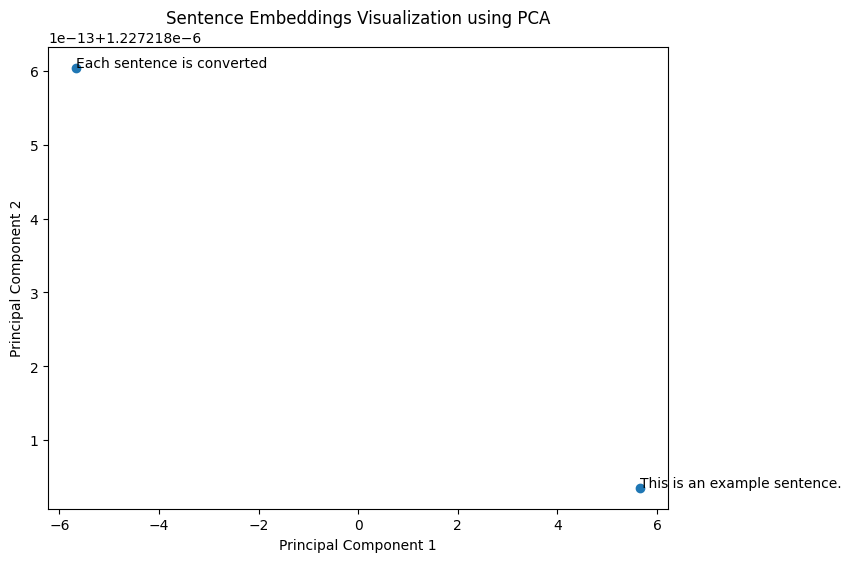

In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example sentences
sentences = ["This is an example sentence.", "Each sentence is converted"]

# Encode sentences using the loaded model
embeddings = loaded_model.encode(sentences)

# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plotting the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

for i, sentence in enumerate(sentences):
    plt.annotate(sentence, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.title('Sentence Embeddings Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

# Example sentences
sentences = ["This is an example sentence.", "Each sentence is converted"]

# Encode sentences using the loaded model
embeddings = loaded_model.encode(sentences)

# Calculate cosine similarity
similarity = cosine_similarity(embeddings)
print("Cosine similarity matrix:\n", similarity)


Cosine similarity matrix:
 [[1.0000002  0.72055304]
 [0.72055304 1.        ]]
